Для воспроизводимости кода установим определенную версию tensorflow и keras

In [ ]:
!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 3.9MB 59.8MB/s 
     |████████████████████████████████| 450kB 50.5MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.1.0
We are using Keras 2.2.4-tf


In [ ]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b4609bd1-0ecc-06b1-b454-6bd0bd6f4877)


In [ ]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Mon Jan 18 09:36:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W /  70W |    111MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MNIST

In [ ]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


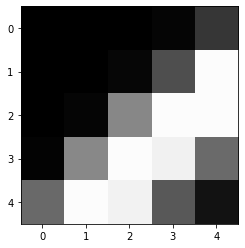

Пример картинки:


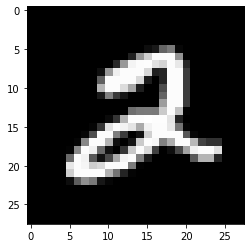

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [ ]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

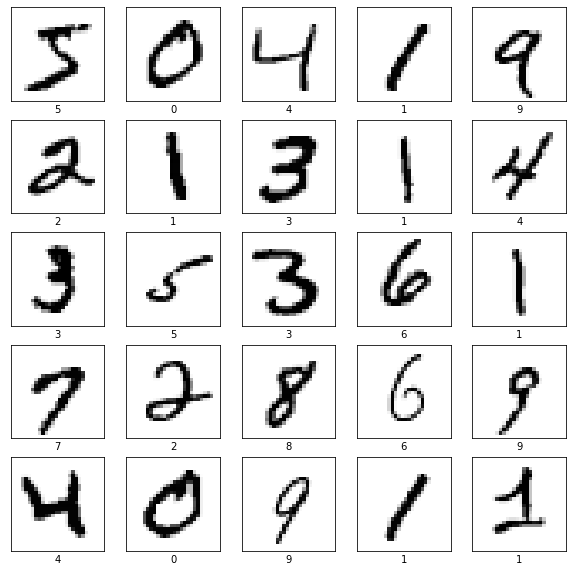

In [ ]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [ ]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [ ]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [ ]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


# Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="500">


Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [ ]:
clear_session()

In [ ]:
# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 84us/sample - loss: 0.3076 - accuracy: 0.9072 - val_loss: 0.1723 - val_accuracy: 0.9477
Epoch 2/10
60000/60000 [==============================] - 3s 55us/sample - loss: 0.1394 - accuracy: 0.9575 - val_loss: 0.1207 - val_accuracy: 0.9627
Epoch 3/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.1029 - accuracy: 0.9679 - val_loss: 0.1212 - val_accuracy: 0.9620
Epoch 4/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0858 - accuracy: 0.9725 - val_loss: 0.1131 - val_accuracy: 0.9627
Epoch 5/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0695 - accuracy: 0.9770 - val_loss: 0.0867 - val_accuracy: 0.9725
Epoch 6/10
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0609 - accuracy: 0.9801 - val_loss: 0.0916 - val_accuracy: 0.9721
Epoch 7/10
60000/60000 [==============================] 

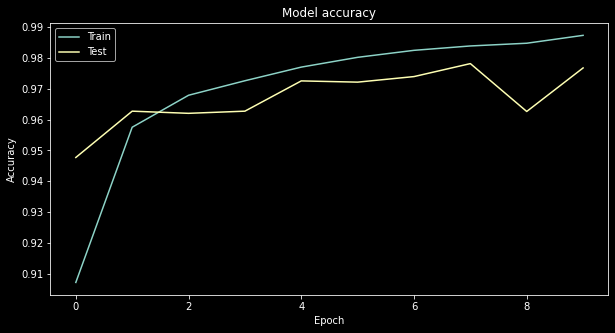

In [ ]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

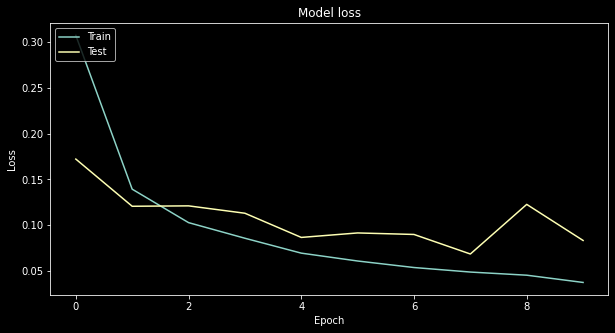

In [ ]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.predict(x_val_float)

array([[5.16309395e-09, 2.51561949e-09, 2.63154135e-07, ...,
        9.99706447e-01, 5.20584571e-08, 6.56640486e-06],
       [4.13120718e-11, 1.50304317e-07, 9.99999881e-01, ...,
        6.66432798e-10, 1.42650780e-09, 2.07623122e-19],
       [7.00947023e-10, 9.99955773e-01, 3.47515368e-07, ...,
        2.99322255e-05, 4.38823662e-07, 9.54688595e-09],
       ...,
       [3.54990549e-17, 7.72185163e-11, 3.41644336e-14, ...,
        3.64319028e-08, 1.10934095e-10, 2.76302643e-08],
       [4.86421525e-09, 5.38423126e-11, 5.98918137e-10, ...,
        2.38843079e-08, 2.95889436e-06, 4.44935339e-11],
       [4.53522700e-15, 1.74615463e-13, 4.53151579e-12, ...,
        3.85364836e-18, 1.50564687e-13, 3.83416884e-14]], dtype=float32)

In [ ]:
model.predict_classes(x_val_float)

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
# аналогично
np.argmax(model.predict(x_val_float), axis = 1)

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

Test Accuracy:  0.9767
